In [15]:
%%capture
pip install -r requirements.txt


Daily ledger for 2024-08-20 generated with 11 entries.
Total Debits: 1798.76, Total Credits: 1811.4217699999997
The ledger is NOT balanced.
Daily ledger for 2024-08-21 generated with 11 entries.
Total Debits: 2729.31, Total Credits: 2651.9891199999997
The ledger is NOT balanced.
Daily ledger for 2024-08-22 generated with 13 entries.
Total Debits: 1321.0799999999997, Total Credits: 1087.5541789999995
The ledger is NOT balanced.
Daily ledger for 2024-08-23 generated with 11 entries.
Total Debits: 3034.23, Total Credits: 3085.2171649999996
The ledger is NOT balanced.
Daily ledger for 2024-08-24 generated with 10 entries.
Total Debits: 1895.2, Total Credits: 1895.2
The ledger is balanced.
Daily ledger for 2024-08-25 generated with 10 entries.
Total Debits: 1855.34, Total Credits: 1855.34
The ledger is balanced.
Daily ledger for 2024-08-26 generated with 12 entries.
Total Debits: 2983.7, Total Credits: 3007.6807399999993
The ledger is NOT balanced.
Daily ledger for 2024-08-27 generated with

,Assets,Liabilities and Equity
Cash,-1180.24,NaN
Loans and Advances,-17514.15,NaN
Client Deposits,NaN,-19296.898218
Capital,NaN,100000.000000
Retained Earnings,NaN,258.835282


,Revenue,Expenses,Net Income
Fee Income,167.020000,0.0,258.835282
FX Gain,91.815282,0.0,258.835282
FX Loss,0.000000,0.0,258.835282


Monthly financial statements generated.


{'Capital Adequacy Ratio (CAR)': '20.05%'}

Regulatory ratios calculated.


,transaction_id,date,client_id,type,amount,currency


,client_id,amount


Regulatory reports generated.


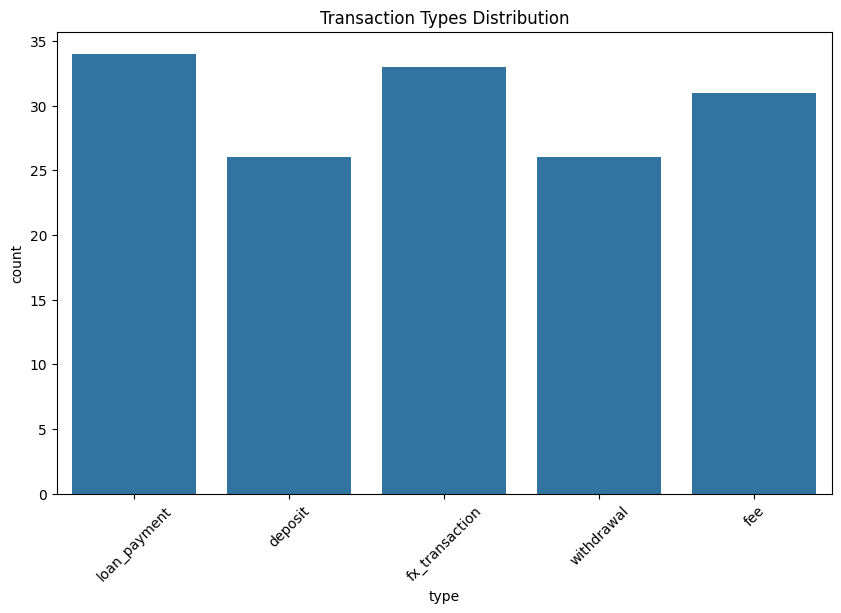

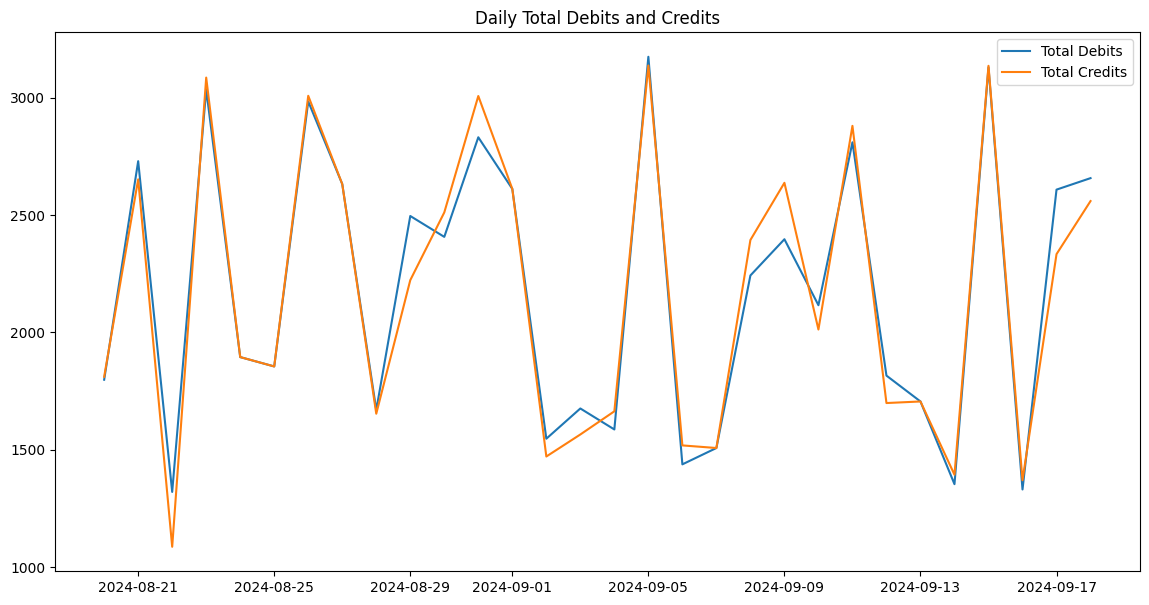

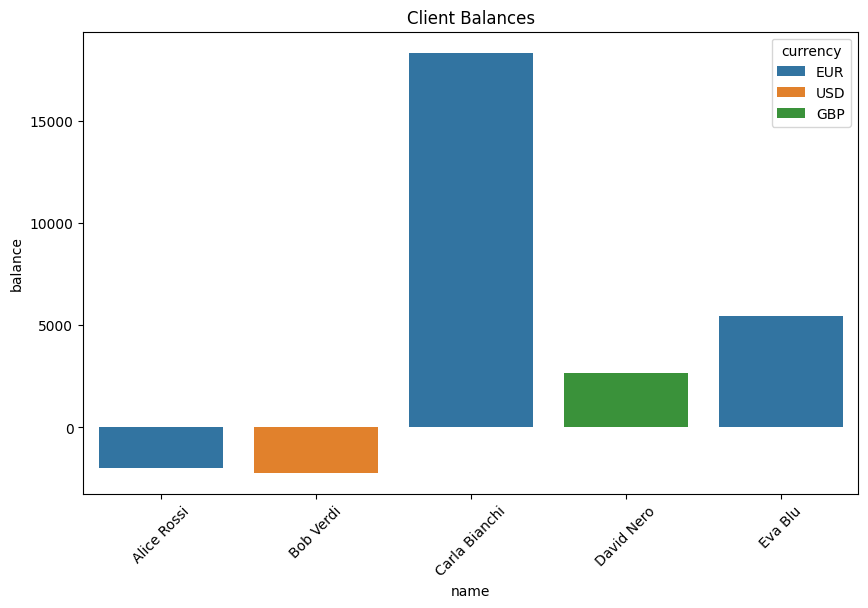

In [1]:
# Bank Simulation Notebook with IFRS Compliance and Context Managers

# Import Necessary Modules
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Initialize Database and Tables
def initialize_database():
    with sqlite3.connect('bank_simulation.db') as conn:
        cursor = conn.cursor()
        # Create clients table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS clients (
                client_id INTEGER PRIMARY KEY,
                name TEXT,
                account_type TEXT,
                currency TEXT,
                balance REAL
            )
        ''')
        # Create ledger_entries table for double-entry bookkeeping
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS ledger_entries (
                entry_id INTEGER PRIMARY KEY AUTOINCREMENT,
                date TEXT,
                transaction_id INTEGER,
                account TEXT,
                debit REAL,
                credit REAL,
                description TEXT,
                FOREIGN KEY(transaction_id) REFERENCES transactions(transaction_id)
            )
        ''')
        # Create transactions table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS transactions (
                transaction_id INTEGER PRIMARY KEY AUTOINCREMENT,
                date TEXT,
                client_id INTEGER,
                type TEXT,
                amount REAL,
                currency TEXT,
                FOREIGN KEY(client_id) REFERENCES clients(client_id)
            )
        ''')
        conn.commit()

initialize_database()

# Create Mock Clients
def insert_clients():
    clients = [
        (1, 'Alice Rossi', 'savings', 'EUR', 10000.00),
        (2, 'Bob Verdi', 'checking', 'USD', 5000.00),
        (3, 'Carla Bianchi', 'corporate', 'EUR', 25000.00),
        (4, 'David Nero', 'savings', 'GBP', 8000.00),
        (5, 'Eva Blu', 'checking', 'EUR', 12000.00),
        # Add more clients as needed
    ]
    with sqlite3.connect('bank_simulation.db') as conn:
        cursor = conn.cursor()
        cursor.executemany('''
            INSERT OR REPLACE INTO clients (client_id, name, account_type, currency, balance)
            VALUES (?, ?, ?, ?, ?)
        ''', clients)
        conn.commit()

insert_clients()

# Define Transaction Functions with IFRS Compliance
def record_ledger_entry(conn, date, transaction_id, account, debit, credit, description):
    cursor = conn.cursor()
    cursor.execute('''
        INSERT INTO ledger_entries (date, transaction_id, account, debit, credit, description)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', (date, transaction_id, account, debit, credit, description))

def deposit(client_id, amount, currency, date):
    with sqlite3.connect('bank_simulation.db') as conn:
        cursor = conn.cursor()
        # Update client's balance (Liability increases)
        cursor.execute('''
            UPDATE clients SET balance = balance + ?
            WHERE client_id = ? AND currency = ?
        ''', (amount, client_id, currency))
        # Record the transaction
        cursor.execute('''
            INSERT INTO transactions (date, client_id, type, amount, currency)
            VALUES (?, ?, 'deposit', ?, ?)
        ''', (date, client_id, amount, currency))
        transaction_id = cursor.lastrowid
        # Double-entry ledger entries according to IFRS 9
        # Debit Cash/Bank Account (Asset increases)
        record_ledger_entry(conn, date, transaction_id, 'Cash', amount, 0, f'Deposit from Client {client_id}')
        # Credit Client Deposits (Liability increases)
        record_ledger_entry(conn, date, transaction_id, 'Client Deposits', 0, amount, f'Deposit to Client {client_id} Account')
        conn.commit()

def withdraw(client_id, amount, currency, date):
    with sqlite3.connect('bank_simulation.db') as conn:
        cursor = conn.cursor()
        # Update client's balance (Liability decreases)
        cursor.execute('''
            UPDATE clients SET balance = balance - ?
            WHERE client_id = ? AND currency = ?
        ''', (amount, client_id, currency))
        # Record the transaction
        cursor.execute('''
            INSERT INTO transactions (date, client_id, type, amount, currency)
            VALUES (?, ?, 'withdrawal', ?, ?)
        ''', (date, client_id, -amount, currency))
        transaction_id = cursor.lastrowid
        # Double-entry ledger entries according to IFRS 9
        # Debit Client Deposits (Liability decreases)
        record_ledger_entry(conn, date, transaction_id, 'Client Deposits', amount, 0, f'Withdrawal from Client {client_id} Account')
        # Credit Cash/Bank Account (Asset decreases)
        record_ledger_entry(conn, date, transaction_id, 'Cash', 0, amount, f'Cash paid to Client {client_id}')
        conn.commit()

def apply_fee(client_id, amount, currency, date):
    with sqlite3.connect('bank_simulation.db') as conn:
        cursor = conn.cursor()
        # Update client's balance (Liability decreases)
        cursor.execute('''
            UPDATE clients SET balance = balance - ?
            WHERE client_id = ? AND currency = ?
        ''', (amount, client_id, currency))
        # Record the transaction
        cursor.execute('''
            INSERT INTO transactions (date, client_id, type, amount, currency)
            VALUES (?, ?, 'fee', ?, ?)
        ''', (date, client_id, -amount, currency))
        transaction_id = cursor.lastrowid
        # Double-entry ledger entries according to IFRS 15
        # Debit Client Deposits (Liability decreases)
        record_ledger_entry(conn, date, transaction_id, 'Client Deposits', amount, 0, f'Fee Charged to Client {client_id}')
        # Credit Fee Income (Revenue increases)
        record_ledger_entry(conn, date, transaction_id, 'Fee Income', 0, amount, f'Fee Income from Client {client_id}')
        conn.commit()

def loan_payment(client_id, amount, currency, date):
    with sqlite3.connect('bank_simulation.db') as conn:
        cursor = conn.cursor()
        # Update client's balance (Liability decreases)
        cursor.execute('''
            UPDATE clients SET balance = balance - ?
            WHERE client_id = ? AND currency = ?
        ''', (amount, client_id, currency))
        # Record the transaction
        cursor.execute('''
            INSERT INTO transactions (date, client_id, type, amount, currency)
            VALUES (?, ?, 'loan_payment', ?, ?)
        ''', (date, client_id, -amount, currency))
        transaction_id = cursor.lastrowid
        # Double-entry ledger entries according to IFRS 9
        # Debit Client Deposits (Liability decreases)
        record_ledger_entry(conn, date, transaction_id, 'Client Deposits', amount, 0, f'Loan Payment from Client {client_id}')
        # Credit Loans and Advances (Asset decreases)
        record_ledger_entry(conn, date, transaction_id, 'Loans and Advances', 0, amount, f'Loan Payment Received from Client {client_id}')
        conn.commit()

def fx_transaction(client_id, amount, from_currency, to_currency, date):
    with sqlite3.connect('bank_simulation.db') as conn:
        cursor = conn.cursor()
        # Apply IFRS 13 and IAS 21 for fair value measurement and FX rates
        fx_rates = {
            ('EUR', 'USD'): 1.1,
            ('USD', 'EUR'): 0.9,
            ('EUR', 'GBP'): 0.85,
            ('GBP', 'EUR'): 1.15,
            ('USD', 'GBP'): 0.77,
            ('GBP', 'USD'): 1.3
        }
        rate = fx_rates.get((from_currency, to_currency), 1)
        converted_amount = amount * rate
        # Bank's margin
        margin = 0.005  # 0.5%
        bank_rate = rate * (1 + margin)
        bank_converted_amount = amount * bank_rate
        fx_gain_loss = bank_converted_amount - converted_amount
        # Update client's balances (Liabilities)
        # Deduct from original currency
        cursor.execute('''
            UPDATE clients SET balance = balance - ?
            WHERE client_id = ? AND currency = ?
        ''', (amount, client_id, from_currency))
        # Add to new currency
        cursor.execute('''
            UPDATE clients SET balance = balance + ?
            WHERE client_id = ? AND currency = ?
        ''', (bank_converted_amount, client_id, to_currency))
        # Record the transaction
        cursor.execute('''
            INSERT INTO transactions (date, client_id, type, amount, currency)
            VALUES (?, ?, 'fx_transaction', ?, ?)
        ''', (date, client_id, -amount, from_currency))
        transaction_id = cursor.lastrowid
        # Double-entry ledger entries
        # Debit Client Deposits in From Currency (Liability decreases)
        record_ledger_entry(conn, date, transaction_id, f'Client Deposits ({from_currency})', amount, 0, f'FX Transaction Deduct from Client {client_id} Account')
        # Credit Client Deposits in To Currency (Liability increases)
        record_ledger_entry(conn, date, transaction_id, f'Client Deposits ({to_currency})', 0, bank_converted_amount, f'FX Transaction Add to Client {client_id} Account')
        # Record FX Gain (Revenue increases)
        if fx_gain_loss > 0:
            # Credit FX Gain (Revenue increases)
            record_ledger_entry(conn, date, transaction_id, 'FX Gain', 0, fx_gain_loss, f'FX Gain from Client {client_id}')
        elif fx_gain_loss < 0:
            # Debit FX Loss (Expense increases)
            record_ledger_entry(conn, date, transaction_id, 'FX Loss', -fx_gain_loss, 0, f'FX Loss from Client {client_id}')
        conn.commit()

# Simulate One Day of Transactions
def simulate_one_day(date):
    with sqlite3.connect('bank_simulation.db') as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT client_id, currency FROM clients')
        clients_data = cursor.fetchall()
    for client_id, client_currency in clients_data:
        # Random transaction
        txn_type = np.random.choice(['deposit', 'withdrawal', 'fee', 'loan_payment', 'fx_transaction'])
        amount = round(np.random.uniform(100, 1000), 2)
        if txn_type == 'deposit':
            deposit(client_id, amount, client_currency, date)
        elif txn_type == 'withdrawal':
            withdraw(client_id, amount, client_currency, date)
        elif txn_type == 'fee':
            fee_amount = round(amount * 0.01, 2)  # 1% fee
            apply_fee(client_id, fee_amount, client_currency, date)
        elif txn_type == 'loan_payment':
            loan_payment(client_id, amount, client_currency, date)
        elif txn_type == 'fx_transaction':
            # Choose a different currency for FX
            currencies = ['EUR', 'USD', 'GBP']
            currencies.remove(client_currency)
            to_currency = np.random.choice(currencies)
            fx_transaction(client_id, amount, client_currency, to_currency, date)

# Generate Daily Ledger
def generate_daily_ledger(date):
    with sqlite3.connect('bank_simulation.db') as conn:
        df = pd.read_sql_query('''
            SELECT * FROM ledger_entries WHERE date = ?
        ''', conn, params=(date,))
    df.to_csv(f'daily_ledger_{date}.csv', index=False)
    total_debits = df['debit'].sum()
    total_credits = df['credit'].sum()
    print(f'Daily ledger for {date} generated with {len(df)} entries.')
    print(f'Total Debits: {total_debits}, Total Credits: {total_credits}')
    if round(total_debits, 2) == round(total_credits, 2):
        print('The ledger is balanced.')
    else:
        print('The ledger is NOT balanced.')

# Simulate One Month
def simulate_one_month():
    start_date = datetime.now() - timedelta(days=29)
    for i in range(30):
        current_date = (start_date + timedelta(days=i)).strftime('%Y-%m-%d')
        simulate_one_day(current_date)
        generate_daily_ledger(current_date)

simulate_one_month()

# Generate Monthly Financial Statements
def generate_monthly_reports():
    with sqlite3.connect('bank_simulation.db') as conn:
        # Ledger entries for the month
        df_ledger = pd.read_sql_query('SELECT * FROM ledger_entries', conn)
    # Check if the ledger balances
    total_debits = df_ledger['debit'].sum()
    total_credits = df_ledger['credit'].sum()
    print(f'Monthly Total Debits: {total_debits}, Total Credits: {total_credits}')
    if round(total_debits, 2) == round(total_credits, 2):
        print('The monthly ledger is balanced.')
    else:
        print('The monthly ledger is NOT balanced.')
    # Prepare Financial Statements according to IAS 1
    # Balance Sheet
    # Assets
    cash_debits = df_ledger[df_ledger['account'] == 'Cash']['debit'].sum()
    cash_credits = df_ledger[df_ledger['account'] == 'Cash']['credit'].sum()
    cash_balance = cash_debits - cash_credits
    loans_debits = df_ledger[df_ledger['account'] == 'Loans and Advances']['debit'].sum()
    loans_credits = df_ledger[df_ledger['account'] == 'Loans and Advances']['credit'].sum()
    loans_and_advances = loans_debits - loans_credits
    assets = {'Cash': cash_balance, 'Loans and Advances': loans_and_advances}
    # Liabilities
    client_deposits_debits = df_ledger[df_ledger['account'].str.contains('Client Deposits')]['debit'].sum()
    client_deposits_credits = df_ledger[df_ledger['account'].str.contains('Client Deposits')]['credit'].sum()
    client_deposits = client_deposits_credits - client_deposits_debits
    liabilities = {'Client Deposits': client_deposits}
    # Equity
    capital = 100000  # Initial capital
    # Calculate Retained Earnings
    fee_income = df_ledger[df_ledger['account'] == 'Fee Income']['credit'].sum()
    fx_gain = df_ledger[df_ledger['account'] == 'FX Gain']['credit'].sum()
    fx_loss = df_ledger[df_ledger['account'] == 'FX Loss']['debit'].sum()
    retained_earnings = fee_income + fx_gain - fx_loss
    equity = {'Capital': capital, 'Retained Earnings': retained_earnings}
    balance_sheet = pd.DataFrame({'Assets': assets, 'Liabilities and Equity': {**liabilities, **equity}})
    display(balance_sheet)
    # Income Statement
    income_statement = pd.DataFrame({
        'Revenue': {
            'Fee Income': fee_income,
            'FX Gain': fx_gain,
        },
        'Expenses': {
            'FX Loss': fx_loss,
        }
    }).fillna(0)
    income_statement['Net Income'] = income_statement['Revenue'].sum() - income_statement['Expenses'].sum()
    display(income_statement)
    # Save to CSV
    balance_sheet.to_csv('monthly_balance_sheet.csv')
    income_statement.to_csv('monthly_income_statement.csv')
    print('Monthly financial statements generated.')
    return retained_earnings  # Return retained earnings for use in regulatory ratios

# Call generate_monthly_reports and store retained earnings
retained_earnings = generate_monthly_reports()

# Calculate Regulatory Ratios
def calculate_regulatory_ratios(retained_earnings):
    # Simplified calculations
    total_risk_weighted_assets = 500000  # Placeholder value
    total_capital = 100000 + retained_earnings  # Capital + Retained Earnings
    car = (total_capital / total_risk_weighted_assets) * 100
    ratios = {
        'Capital Adequacy Ratio (CAR)': f'{car:.2f}%',
        # LCR and NSFR can be added with appropriate calculations
    }
    display(ratios)
    with open('regulatory_ratios.json', 'w') as f:
        json.dump(ratios, f)
    print('Regulatory ratios calculated.')

calculate_regulatory_ratios(retained_earnings)

# Generate Regulatory Reports
def generate_regulatory_reports():
    with sqlite3.connect('bank_simulation.db') as conn:
        # Suspicious Transactions (AML Compliance)
        df_transactions = pd.read_sql_query('SELECT * FROM transactions', conn)
    suspicious_transactions = df_transactions[df_transactions['amount'].abs() > 10000]
    display(suspicious_transactions)
    suspicious_transactions.to_csv('suspicious_transactions.csv', index=False)
    # Large Exposures
    large_exposures = df_transactions.groupby('client_id')['amount'].sum().reset_index()
    large_exposures = large_exposures[large_exposures['amount'].abs() > 50000]
    display(large_exposures)
    large_exposures.to_csv('large_exposures.csv', index=False)
    print('Regulatory reports generated.')

generate_regulatory_reports()

# Visualizations
with sqlite3.connect('bank_simulation.db') as conn:
    df_transactions = pd.read_sql_query('SELECT * FROM transactions', conn)
    df_ledger = pd.read_sql_query('SELECT * FROM ledger_entries', conn)
    df_clients = pd.read_sql_query('SELECT * FROM clients', conn)

# Transaction Types Distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df_transactions, x='type')
plt.title('Transaction Types Distribution')
plt.xticks(rotation=45)
plt.show()

# Total Debit and Credit Amounts Over Time
df_ledger['date'] = pd.to_datetime(df_ledger['date'])
daily_totals = df_ledger.groupby('date').agg({'debit': 'sum', 'credit': 'sum'}).reset_index()
plt.figure(figsize=(14,7))
plt.plot(daily_totals['date'], daily_totals['debit'], label='Total Debits')
plt.plot(daily_totals['date'], daily_totals['credit'], label='Total Credits')
plt.title('Daily Total Debits and Credits')
plt.legend()
plt.show()

# Client Balances
plt.figure(figsize=(10,6))
sns.barplot(data=df_clients, x='name', y='balance', hue='currency')
plt.title('Client Balances')
plt.xticks(rotation=45)
plt.show()
